<a href="https://colab.research.google.com/github/YuehMintTai/RPython/blob/main/Class08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#三軍總醫院北投分院統計及實驗設計課程之八
## 2021/7/13
## ytai1123@gmail.com
### 使用方法:


1.   使用gmail帳號登入
2.   按"執行階段" -->"全部執行" 以執行全部內容, 若要個別執行可點選每格程式左方箭頭或按 Control + Enter 鍵執行。

In [1]:
##0-1
!git clone https://github.com/YuehMintTai/RPython.git

Cloning into 'RPython'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 131 (delta 73), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (131/131), 2.74 MiB | 6.84 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
##0-2
!pip install rpy2

In [3]:
##0-3
%load_ext rpy2.ipython

In [74]:
##8-0-0
import tensorflow as tf
import torch
tf.__version__     ##2.5.0
torch.__version__   ##1.9.0+cu102

'1.9.0+cu102'

In [42]:
##8-0-1 區分所有的資料為testing, validating及training sets
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import numpy as np

df=pd.read_csv('RPython/samples.csv')
df['sex']='男'
df.loc[df['性別']==2,'sex']='女'
x=df[['sex','網路成癮分數YDQ','家庭滿意度apgar','年齡']]
x=pd.get_dummies(data=x,drop_first=True)
y=df['自殺意念01'].astype(int).to_frame()
all_df=pd.concat([x,y],axis=1)
all_df['remainder']=all_df.index%6
all_df['group']='training'
all_df.loc[all_df['remainder']==0,'group']='testing'
all_df.loc[all_df['remainder']==1,'group']='validating'
all_df.loc[all_df['remainder']==2,'group']='validating'

all_df['年齡'].groupby(all_df['group']).mean()
groupList=['training','validating','testing']
all_df['groupNo']=0
all_df.loc[all_df['group']=='validating','groupNo']=1
all_df.loc[all_df['group']=='testing','groupNo']=2
all_df.tail()

,網路成癮分數YDQ,家庭滿意度apgar,年齡,sex_男,自殺意念01,remainder,group,groupNo
183,8,9.0,27.0,1,0,3,training,0
184,5,5.0,27.0,1,1,4,training,0
185,5,7.0,27.0,1,0,5,training,0
186,2,0.0,21.0,1,1,0,testing,2
187,0,0.0,25.0,1,1,1,validating,1


In [76]:
##8-0-2 Chi-square and ANOVA
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
print(pd.crosstab(all_df['group'],all_df['自殺意念01']))
##chi-square test確定 自殺意念01 沒有過度集中在某組....
Chi2=chi2(all_df['groupNo'].to_numpy().reshape(-1,1),all_df['自殺意念01'].to_numpy())
print('chi2={}, p={}'.format(round(Chi2[0].item(),3),round(Chi2[1].item(),3)))
##ANOVA確定年齡沒有過度集中在某組
print('='*30)
F=f_classif(all_df['年齡'].to_numpy().reshape(-1,1),all_df['group'].to_numpy())
print(all_df.groupby('group')['年齡'].mean())
print('ANOVA F={}, p={}'.format(round(F[0].item(),3),round(F[1].item(),3)))

自殺意念01       0   1
group             
testing     23   9
training    77  16
validating  53  10
chi2=0.986, p=0.321
group
testing       21.385385
training      21.752499
validating    20.687376
Name: 年齡, dtype: float64
ANOVA F=1.126, p=0.327


In [98]:
##8-0-3 區分 training, validation, testing sets..
y_test=all_df.loc[all_df['group']=='testing']['自殺意念01'].to_frame()
x_test=all_df.loc[all_df['group']=='testing'][['網路成癮分數YDQ','家庭滿意度apgar','年齡','sex_男']]
y_vald=all_df.loc[all_df['group']=='validating']['自殺意念01'].to_frame()
x_vald=all_df.loc[all_df['group']=='validating'][['網路成癮分數YDQ','家庭滿意度apgar','年齡','sex_男']]
y_train=all_df.loc[all_df['group']=='training']['自殺意念01'].to_frame()
x_train=all_df.loc[all_df['group']=='training'][['網路成癮分數YDQ','家庭滿意度apgar','年齡','sex_男']]
print('cases number of train={}, of validation={}, of test={} '.format(len(x_train),len(x_vald),len(x_test)))

cases number of train=93, of validation=63, of test=32 


In [ ]:
##8-1 使用sklearn Logistic regression ...


In [6]:
##8-3 使用tensorflow+validation作模型預測...
import tensorflow as tf
from sklearn.metrics import roc_auc_score
model1=tf.keras.Sequential()
model1.add(tf.keras.layers.Dense(1,input_dim=3,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy',tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
model1.fit(x_train,y_train,epochs=10,batch_size=10,validation_split=0.25)
scores=model1.evaluate(x_test,y_test)
predicted_prob=model1.predict(x_test)
predicted_prob

Epoch 1/10
12/12 [==============================] - 2s 54ms/step - loss: 1.0656 - accuracy: 0.5625 - auc: 0.6869 - precision: 0.3115 - recall: 0.7308 - val_loss: 0.7849 - val_accuracy: 0.6842 - val_auc: 0.8429 - val_precision: 0.1538 - val_recall: 0.6667
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 1.0219 - accuracy: 0.5536 - auc: 0.6939 - precision: 0.3000 - recall: 0.6923 - val_loss: 0.7494 - val_accuracy: 0.6842 - val_auc: 0.8429 - val_precision: 0.1538 - val_recall: 0.6667
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.9841 - accuracy: 0.6161 - auc: 0.7033 - precision: 0.3396 - recall: 0.6923 - val_loss: 0.7126 - val_accuracy: 0.7368 - val_auc: 0.8429 - val_precision: 0.1818 - val_recall: 0.6667
Epoch 4/10
12/12 [==============================] - 0s 5ms/step - loss: 0.9459 - accuracy: 0.6429 - auc: 0.7042 - precision: 0.3600 - recall: 0.6923 - val_loss: 0.6796 - val_accuracy: 0.7632 - val_auc: 0.8429 - val_precision: 0.2000 - va

array([[0.06042182],
       [0.28154752],
       [0.27033064],
       [0.03039441],
       [0.06418741],
       [0.13049525],
       [0.61122787],
       [0.13699934],
       [0.9926805 ],
       [0.13049525],
       [0.98412246],
       [0.9986367 ],
       [0.02855086],
       [0.4181081 ],
       [0.62545943],
       [0.61122787],
       [0.83985686],
       [0.9926805 ],
       [0.19485387],
       [0.6800553 ],
       [0.55273825],
       [0.20516801],
       [0.03039441],
       [0.9002    ],
       [0.9659021 ],
       [0.03039441],
       [0.03039441],
       [0.20516801],
       [0.4181081 ],
       [0.9850378 ],
       [0.19550776],
       [0.9926805 ],
       [0.9105255 ],
       [0.03039441],
       [0.99910533],
       [0.24720678],
       [0.03039441],
       [0.0132539 ]], dtype=float32)

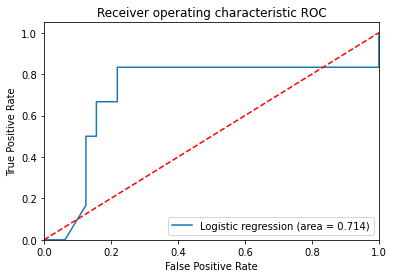

In [7]:
result=np.concatenate((y_test.to_numpy(), predicted_prob),axis=1)
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot as plt
AUC面積=roc_auc_score(y_test, predicted_prob) ##0.6973180076628352

fpr,tpr,thresholds=roc_curve(y_test,predicted_prob)
plt.figure()
plt.plot(fpr,tpr,label='Logistic regression (area = %0.3f)'%AUC面積)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ROC')
plt.legend(loc="lower right")
plt.show()

In [8]:
y_test.to_numpy().shape
predicted_prob.shape

(38, 1)